In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import json

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','efter'])

In [4]:
df = pd.read_csv(r'low_csv.csv',sep=';')
print(df.caption.unique())
df


["The design sale. It's on. Join in. Spoil yourself. #bolia #thedesignsale"
 'The design sale is here. Save up to 50% on more than 100 great designs #thedesignsale  #bolia'
 'New issue of Plaza interior magazine. We ❤ that you choose our Madison sofa and Como marble coffee table for the cover. It looks fantastic @plazainterior #regram #bolia #lovelifeandfurniture'
 "We keep going with the creative ideas for next years lookbook. It's going to be a long and fantastic evening at the same time #bolia #lovelifeandfurniture #greatjob"
 'Creating next years lookbook #bolia #lovelifeandfurniture #bestever'
 'The Bolia store in Roskilde (Denmark) just had an extra happy customer today. Rasmus had won a 10.000 DKK gift certificate to the Roskilde shopping mall and chose to spend it on furniture: DoubleUp dining table, Plano mirror, spotted hooks and a Berlin bench. Huge congratulations from us and thanks for shopping in our store 👍'
 'Thanks to Frantz Longhi for giving a talk about Kähler.'
 'De

,s_no,id,ig_id,comments_count,like_count,media_type,media_url,permalink,timestamp,year,caption,hashtag_caption,comments_text,type
0,1515,17842413076015891,622321009385352447,0,58,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/11...,https://www.instagram.com/p/ii7aksrSz_/,2013-12-30T12:27:47+0000,2013,The design sale. It's on. Join in. Spoil yours...,"[#bolia, #thedesignsale]",NaN,low
1,1516,17842408201015891,614318345594679163,1,48,IMAGE,https://scontent.xx.fbcdn.net/v/t50.2886-16/11...,https://www.instagram.com/p/iGf0fQLS97/,2013-12-19T11:27:55+0000,2013,The design sale is here. Save up to 50% on mor...,"[#thedesignsale, #bolia]",Looks great #bolia 👍$,low
2,1517,17842407679015891,612956485310033567,0,61,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/11...,https://www.instagram.com/p/iBqK0BrS6f/,2013-12-17T14:22:08+0000,2013,New issue of Plaza interior magazine. We ❤ tha...,"[#regram, #bolia, #lovelifeandfurniture]",NaN,low
3,1519,17842406257015891,609465998347414823,0,78,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/11...,https://www.instagram.com/p/h1QhiuLS0n/,2013-12-12T18:47:10+0000,2013,We keep going with the creative ideas for next...,"[#bolia, #lovelifeandfurniture, #greatjob]",NaN,low
4,1520,17842405759015891,608651841914089164,0,68,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/11...,https://www.instagram.com/p/hyXaAdLS7M/,2013-12-11T15:49:35+0000,2013,Creating next years lookbook #bolia #lovelifea...,"[#bolia, #lovelifeandfurniture, #bestever]",NaN,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,452,17913496828177793,1765888427524777142,0,246,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/30...,https://www.instagram.com/p/BiBsiszlmS2/,2018-04-26T08:12:06+0000,2018,Set your expectations sky high with the new Cl...,"[#bolia, #nooneliveslikeyou, #clouds]",NaN,low
412,459,17880182221205467,1760890084598756223,1,274,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/30...,https://www.instagram.com/p/Bhv8DPNBDN_/,2018-04-19T10:41:17+0000,2018,"Clean lines, simple geometry and a light expre...","[#bolia, #nooneliveslikeyou, #aro]",💫💫$,low
413,461,17938852150029168,1759565243082947541,2,191,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/30...,https://www.instagram.com/p/BhrO0QZFTvV/,2018-04-17T14:49:04+0000,2018,"""Be Brave, I tell myself as I stare into the d...","[#nooneliveslikeyou, #passionproject, #staytuned]",🙌🏻$Like it! 😄$,low
414,495,17930724598013550,1734892378189641947,2,256,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/28...,https://www.instagram.com/p/BgTk20Vhrjb/,2018-03-14T13:48:29+0000,2018,Bolia Design Award 2018 - 3/8 ———————- Nomad C...,"[#bolia, #designaward, #vote]",👍🙌$@srda11$,low


In [5]:
df['data'] = df.caption.tolist()

In [6]:
# Convert to list

data = df.caption.tolist()

df['data'] = [re.sub('\s*@\s*\s?', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('\?', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('\_', ' ', str(sent)) for sent in df['data']]

df['data'] = [re.sub('@"[\d-]"', ' ', str(sent)) for sent in df['data']]

# Remove new line characters
df['data'] = [re.sub('\s+', ' ', str(sent)) for sent in df['data']]

# Remove distracting single quotes
df['data'] = [re.sub("\'", " ", str(sent)) for sent in df['data']]

df['data']=df['data'].str.lower()

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'design', 'sale', 'it', 'on', 'join', 'in', 'spoil', 'yourself', 'bolia', 'thedesignsale']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'design', 'sale', 'it', 'on', 'join', 'in', 'spoil', 'yourself', 'bolia', 'thedesignsale']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['design', 'sale', 'join']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=80,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"collaboration" + 0.022*"music" + 0.018*"art" + 0.018*"fashion" + '
  '0.017*"line" + 0.017*"blur" + 0.014*"choose" + 0.014*"soon" + 0.014*"come" '
  '+ 0.013*"can"'),
 (1,
  '0.080*"new" + 0.036*"collection" + 0.033*"design" + 0.023*"love" + '
  '0.022*"store" + 0.017*"will" + 0.014*"sofa" + 0.011*"here" + 0.011*"get" + '
  '0.011*"ready"'),
 (2,
  '0.021*"fabric" + 0.016*"year" + 0.015*"so" + 0.014*"know" + 0.013*"see" + '
  '0.012*"make" + 0.012*"sure" + 0.012*"much" + 0.012*"look" + 0.011*"next"'),
 (3,
  '0.029*"winner" + 0.024*"find" + 0.018*"week" + 0.013*"lucky" + 0.012*"vote" '
  '+ 0.012*"win" + 0.012*"link" + 0.012*"first" + 0.012*"danish" + '
  '0.012*"just"'),
 (4,
  '0.033*"chair" + 0.015*"can" + 0.014*"table" + 0.012*"very" + '
  '0.011*"scandinavian" + 0.010*"simple" + 0.010*"material" + 0.009*"modern" + '
  '0.009*"tell" + 0.009*"cloud"')]


In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.290567958309334

Coherence Score:  0.338681682971334


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.190968  0.085639       1        1  39.087791
0      0.087777 -0.240812       2        1  17.357782
3     -0.067402  0.019964       3        1  16.660892
4      0.226395  0.164362       4        1  14.654024
2     -0.055802 -0.029153       5        1  12.239512, topic_info=               Term        Freq       Total Category  logprob  loglift
15              new  135.000000  135.000000  Default  30.0000  30.0000
244      collection   61.000000   61.000000  Default  29.0000  29.0000
197           chair   21.000000   21.000000  Default  28.0000  28.0000
735   collaboration   23.000000   23.000000  Default  27.0000  27.0000
227          winner   20.000000   20.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
909           light    4.721510    9.177030   Topic5  -4.7165   1.4359
28             year    8.494103   25.363747   Topic5  -4.1293   1.0066
12             look    6.159494   16.986378   Topic5  -4.4507   1.0861
983  livelovecreate    4.842533   12.519600   Topic5  -4.6912   1.1506
126             way    4.239111   11.652740   Topic5  -4.8243   1.0893

[240 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1311      4  0.923477  adventure
753       3  0.177392  aesthetic
753       4  0.709568  aesthetic
136       2  0.915328        all
121       4  0.969164    amazing
...     ...       ...        ...
1298      4  0.923778       wool
108       1  0.547244       work
108       3  0.456037       work
28        1  0.670248       year
28        5  0.315411       year

[258 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])

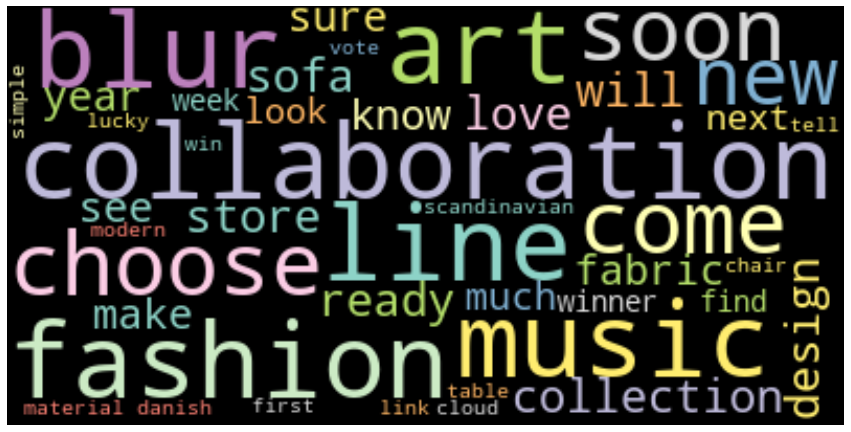

In [16]:
from wordcloud import WordCloud

from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in lda_model.print_topics())
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()